# import 3rd lib

In [1]:
from pynq import Overlay
from pynq.lib.iic import *
from pynq.lib.video import *
from time import sleep
from pynq import allocate
import matplotlib.pyplot as plt
import cv2
import math
import time
import os
import socket
import shutil

# Instantiate FPGA

In [2]:
ol = Overlay("design_1.bit")#_single_bak
ol.ip_dict

{'axi_intc_0': {'addr_range': 65536,
  'device': <pynq.pl_server.device.XlnkDevice at 0xb3aa8ab0>,
  'driver': pynq.overlay.DefaultIP,
  'fullpath': 'axi_intc_0',
  'gpio': {},
  'interrupts': {},
  'mem_id': 's_axi',
  'parameters': {'C_ADDR_WIDTH': '32',
   'C_ASYNC_INTR': '0xFFFFFFF8',
   'C_BASEADDR': '0x41800000',
   'C_CASCADE_MASTER': '0',
   'C_DISABLE_SYNCHRONIZERS': '0',
   'C_ENABLE_ASYNC': '0',
   'C_EN_CASCADE_MODE': '0',
   'C_FAMILY': 'zynq',
   'C_HAS_CIE': '1',
   'C_HAS_FAST': '0',
   'C_HAS_ILR': '0',
   'C_HAS_IPR': '1',
   'C_HAS_IVR': '1',
   'C_HAS_SIE': '1',
   'C_HIGHADDR': '0x4180FFFF',
   'C_INSTANCE': 'design_1_axi_intc_0_0',
   'C_IRQ_ACTIVE': '0x1',
   'C_IRQ_CONNECTION': '0',
   'C_IRQ_IS_LEVEL': '1',
   'C_IVAR_RESET_VALUE': '0x0000000000000010',
   'C_KIND_OF_EDGE': '0xFFFFFFFF',
   'C_KIND_OF_INTR': '0xfffffff8',
   'C_KIND_OF_LVL': '0xFFFFFFFF',
   'C_MB_CLK_NOT_CONNECTED': '1',
   'C_NUM_INTR_INPUTS': '3',
   'C_NUM_SW_INTR': '0',
   'C_NUM_SYNC_FF':

# config UDP parmeters

In [3]:
udp_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)  #
local_addr = ("", 9442)  # 默认本机ip ，指定端口号9441
udp_socket.bind(local_addr)
dst_ip = "192.168.101.163"#目标ip
dst_port = 8000#目标端口

# init vdma

In [4]:
vdma0 = ol.axi_vdma_0
vdma1 = ol.axi_vdma_1
vdma0.writechannel.mode = VideoMode(640, 480, 24)
vdma1.readchannel.mode = vdma0.writechannel.mode
vdma0.readchannel.mode = vdma0.writechannel.mode
frame_out=allocate(shape=(480,640,3), dtype=np.uint8)
frame_out2=allocate(shape=(480,640,3), dtype=np.uint8)

In [5]:
vdma0.writechannel.stop()
vdma0.writechannel.start()
vdma0.readchannel.stop()
vdma1.readchannel.stop()
vdma0.readchannel.start()
vdma1.readchannel.start()
frame_out[:]=255
vdma0.writechannel.writeframe(frame_out)

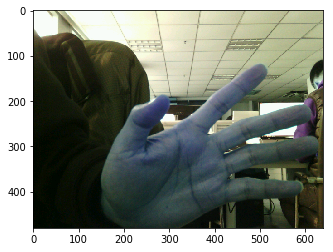

In [10]:
vdma0.writechannel.stop()
vdma0.writechannel.start()
vdma0.readchannel.stop()
vdma1.readchannel.stop()
vdma0.readchannel.start()
vdma1.readchannel.start()

rgb_frame1=vdma0.readchannel.readframe()
rgb_frame2=vdma1.readchannel.readframe()

vdma0.writechannel.writeframe(frame_out)
plt.imshow(rgb_frame1)

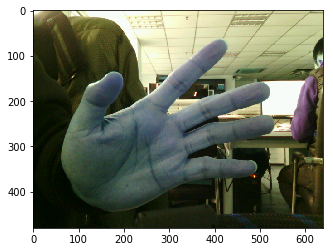

In [11]:
plt.imshow(rgb_frame2)

In [12]:
cv2.imwrite('./L'+str(i)+'.bmp',rgb_frame1)
cv2.imwrite('./R'+str(i)+'.bmp',rgb_frame2)
i=i+1

In [13]:
i=0

In [15]:
rgb_frame1=vdma0.readchannel.readframe()
rgb_frame2=vdma1.readchannel.readframe()
frame_out[:,0:320,:]=rgb_frame1[:,0:320,:]
frame_out[:,320:640,:]=rgb_frame2[:,0:320,:]
vdma0.writechannel.writeframe(frame_out)
cv2.waitKey(10)

-1

In [16]:
#while True:
    #rgb_frame1=vdma0.readchannel.readframe()
    #rgb_frame2=vdma1.readchannel.readframe()
    #frame_out[:,0:320,:]=rgb_frame1[:,0:320,:]
    #frame_out[:,320:640,:]=rgb_frame2[:,0:320,:]
    #vdma0.writechannel.writeframe(frame_out)
    #cv2.waitKey(10)

# init target_detect_ip

In [17]:
target_detect_ip = ol
.target_detect_0
target_detect_ip.write(12*4,200)#二值化阈值 0-255
target_detect_ip.write(13*4,20)#目标最小间隔 0-1000

SyntaxError: invalid syntax (<ipython-input-17-d8603041182f>, line 2)

In [18]:
# define util function

In [19]:
def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255, 0,0), 3)
    img = cv2.line(img, corner, tuple(imgpts[3].ravel()), (255, 255, 0), 3)
    img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0, 255, 0), 3)
    return img


def draw3dbox(img, corners, imgpts):
    imgpts = np.int32(imgpts).reshape(-1,2)
    img = cv2.drawContours(img, [imgpts[:4]],-1,(0,255,0),-3)
    for i, j in zip(range(4),range(4,8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]),(255),3)
    img = cv2.drawContours(img, [imgpts[4:]],-1,(0,0,255),3)
    return img

axis3dbox = np.float32([[0,0,0], [0,30,0], [30,30,0], [30,0,0],
                   [0,0,-30],[0,30,-30],[30,30,-30],[30,0,-30] ])

axis = np.float32([[30,0,0], [0,30,0], [0,0,-30]]).reshape(-1,3)
stereo_cam_mt = np.array([[1.14848345e+03,0,6.67053669e+02],
                            [0,1.15696217e+03,4.10006067e+02],
                            [0,0,1]])
stereo_cam_ds = np.array([0.15991044, -0.52151007,  0.01995543, -0.00157179,  0.33406411])

object_2d_position = np.zeros((4, 2), np.float32)
object_3d_position = np.zeros((4, 3), np.float32)

In [10]:
# maker's 3-point xyz-position [modify these to adapt new makers]

In [11]:
object_3d_position[0]=np.array([0,0,0])
object_3d_position[1]=np.array([75,0,0])
object_3d_position[2]=np.array([40,70,0])
object_3d_position[3]=np.array([40,45,0])

In [12]:
# start

In [13]:
vdma0.writechannel.stop()
vdma0.readchannel.stop()
vdma1.writechannel.stop()
vdma1.readchannel.stop()
vdma0.writechannel.start()
vdma0.readchannel.start()
vdma1.writechannel.start()
vdma1.readchannel.start()
t1=0
t2=0
while 1:
    rgb_frame=vdma0.readchannel.readframe()
    frame_out[:]=rgb_frame
    vdma0.writechannel.writeframe(frame_out)
    cv2.waitKey(2)
    p1_left=target_detect_ip.read(0*4)
    p1_top=target_detect_ip.read(1*4)
    p1_right = target_detect_ip.read(2*4)
    p1_bottom = target_detect_ip.read(3*4)

    p2_left=target_detect_ip.read(4*4)
    p2_top=target_detect_ip.read(5*4)
    p2_right = target_detect_ip.read(6*4)
    p2_bottom = target_detect_ip.read(7*4)

    p3_left=target_detect_ip.read(8*4)
    p3_top=target_detect_ip.read(9*4)
    p3_right = target_detect_ip.read(10*4)
    p3_bottom = target_detect_ip.read(11*4)
    #=============================================
    if p1_left < p2_left:
        object_2d_position[0, 0] = (p1_left+p1_right)/2
        object_2d_position[0, 1] = (p1_top+p1_bottom)/2
        object_2d_position[1, 0] = (p2_left+p2_right)/2
        object_2d_position[1, 1] = (p2_top+p2_bottom)/2
    else:
        object_2d_position[0, 0] = (p2_left+p2_right)/2
        object_2d_position[0, 1] = (p2_top+p2_bottom)/2
        object_2d_position[1, 0] = (p1_left+p1_right)/2
        object_2d_position[1, 1] = (p1_top+p1_bottom)/2
    object_2d_position[2, 0] = (p3_left+p3_right)/2
    object_2d_position[2, 1] = (p3_top+p3_bottom)/2
        
    object_2d_position[3, 0] = ( (object_2d_position[0, 0]+object_2d_position[1, 0])/2 + object_2d_position[2, 0])/2
    object_2d_position[3, 1] = ( (object_2d_position[0, 1]+object_2d_position[1, 1])/2 + object_2d_position[2, 1])/2
    #==============================================
    if object_2d_position.all()!=0 :
        _, rvec, tvec = cv2.solvePnP(object_3d_position, object_2d_position, stereo_cam_mt,stereo_cam_ds) 
        #distance = math.sqrt(tvec[0] ** 2 + tvec[1] ** 2 + tvec[2] ** 2) 
        rvec_matrix = cv2.Rodrigues(rvec)[0]
        proj_matrix = np.hstack((rvec_matrix, tvec))
        eulerAngles = cv2.decomposeProjectionMatrix(proj_matrix)[6] 
        pitch, yaw, roll = eulerAngles[0], eulerAngles[1], eulerAngles[2]
#     ========================================================================================
        ##send_data = "Depth_distance: %.2fmm,3d pose: yaw: %.2f, pitch: %.2f, roll: %.2f" % (distance, yaw, pitch, roll)
        ##posList.append(eulerAngles)
        
        #posDic = {}
        #posList = eulerAngles.tolist()
        #posDic["BallCue"] = posList
        #send_data = json.dumps(posDic)
        #udp_socket.sendto(send_data.encode("utf-8"), (dst_ip, dst_port))
        
        #将旋转向量转到旋转矩阵（罗里格斯变换）rvec->rmat 
        #rmat = cv2.Rodrigues(rvec);
        #再由旋转矩阵求得姿态角
        #theta_z = cv2.fastAtan2(rmat[1][0], rmat[0][0])*57.2958;
        #theta_y = cv2.fastAtan2(-rmat[2][0], sqrt(rmat[2][0] * rmat[2][0] + rmat[2][2] * rmat[2][2]))*57.2958;
        #theta_x = cv2.fastAtan2(rmat[2][1], rmat[2][2])*57.2958;
        #send_data = send_data =" {\"key\":\"fpga_data\",\"rvec\":{\"x\":"+str(rvec[0])+",\"y\":"+str(rvec[1])+",\"z\":"+str(rvec[2])+"},\"tvec\":{\"x\":"+str(tvec[0])+",\"y\":"+str(tvec[1])+",\"z\":"+str(tvec[2])+"}} "
        #send_data = send_data =" {\"key\":\"fpga_data\",\"rvec\":{\"x\":"+str(theta_x)+",\"y\":"+str(theta_y)+",\"z\":"+str(theta_z)+"},\"tvec\":{\"x\":"+str(tvec[0])+",\"y\":"+str(tvec[1])+",\"z\":"+str(tvec[2])+"}} "
        send_data = send_data =" {\"key\":\"fpga_data\",\"rvec\":{\"x\":"+str(yaw)+",\"y\":"+str(pitch)+",\"z\":"+str(roll)+"},\"tvec\":{\"x\":"+str(tvec[0])+",\"y\":"+str(tvec[1])+",\"z\":"+str(tvec[2])+"}} "
        
        udp_socket.sendto(send_data.encode("utf-8"), (dst_ip, dst_port))
    #===============================================
    else:
        send_data="target points not found."
        udp_socket.sendto(send_data.encode("utf-8"), (dst_ip, dst_port))
    cv2.waitKey(1)
vdma0.writechannel.stop()
vdma0.readchannel.stop()
vdma1.writechannel.stop()
vdma1.readchannel.stop()

AttributeError: 'AxiVDMA' object has no attribute 'writechannel'